# **Multiple Linear Regression**

#### **Objectives**:
* Use scikit-learn to implement multiple linear regression
* Create, train, and test a multiple linear regression model on real data

---

#### Import Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the Data

In [112]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
df = pd.read_csv(url)

df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [113]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


`MODELYEAR` is the same for all cars, we can simply drop it along with other categorical variables since we won't need them for this practice.

In [114]:
# Drop categorical varibles
cat_cols = list(df.select_dtypes('object').columns) + ['MODELYEAR']
df = df.drop(cat_cols, axis=1)

Now that you have eliminated some features, take a loook at the relationships among the remaining features.

Analyzing a correlation matrix that displays the pairwise correlations between all features indicates the level of independence between them.

It also indicates how predictive each feature is of the target.

We want to eliminate any strong dependencies or correlations between features by selecting the best one from each correlated group.

In [115]:
emission_corr = df.corr()
emission_corr

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
ENGINESIZE,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154
CYLINDERS,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685
FUELCONSUMPTION_CITY,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000


Look at the bottom row, which shows the correlation between each variable and the target, `CO2EMISSIONS`. Each of these shows a fairly high level of correlation, each exceeding 85% in magnitude. Thus all of these features are good candidates.

Next, examine the correlations of the distinct pairs. `ENGINESIZE` and `CYLINDERS` are highly correlated, but `ENGINESIZE` is more correlated with the target, so we can drop `CYLINDERS`.

Similarly, each of the four fuel economy variables is highly correlated with each other. Since `FUELCONSUMPTION_COMB_MPG` is the most correlated with the target, we can drop the others:
`FUELCONSUMPTION_CITY`, `FUELCONSUMPTION_HWY`, `FUELCONSUMPTION_COMB`.

Notice that `FUELCONSUMPTION_COMB` and `FUELCONSUMPTION_COMB_MPG` are not perfectly correlated. They should be, though, because they measure the same property in different units. In practice, we would investigate why this is the case. We might find out that some or all of the data is not useable as is.

In [116]:
df = df.drop(['CYLINDERS', 'FUELCONSUMPTION_CITY',
               'FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB'], axis=1)

df.head()

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244


To help with selecting predictive features that are not redundant, consider the following scatter matrix, which shows the scatter plots for each pair of input features. The diagonal of the matrix shows each feature's histogram.

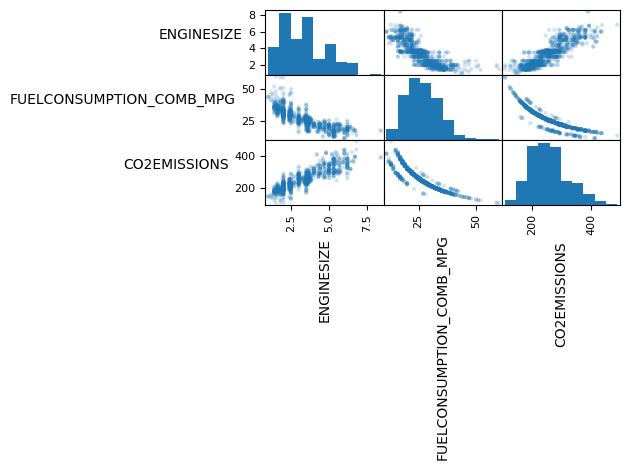

In [117]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2)

# rotate the axis labels for easier to read
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

The relationship between `FUELCONSUMPTION_COMB_MPG` and `CO2EMISSIONS` is non-linear. In addition, you can clearly see three different curves. This suggests exploring the categorical variables to see if they are able to explain these differences.

---

#### **Extract the input features and labels from the data set**

In [197]:
X = df.drop('CO2EMISSIONS', axis=1)
y = df.CO2EMISSIONS

#### **Create train and test datasets**

Randomly split the data into train and test sets, using 80% of the dataset for training and reserving the remaining 20% for testing.

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

#### **Preprocess Selected Features**
You should standardize your input features so the model doesn't inasvertently favor feature due to its magnitude. The typical way to do this is to substract the mean and divide by the standard deviation.

In [200]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In practice, if we want to properly evaluate our model, we should definitely not apply such operations to the entire dataset but to the train and test data separately. There's more to it than that.

In [203]:
pd.DataFrame(X_train_scaled).describe().round(2)

,0,1
count,853.00,853.00
mean,0.00,0.00
std,1.00,1.00
min,-1.67,-2.10
25%,-0.96,-0.73
50%,0.03,-0.04
75%,0.74,0.64
max,3.57,4.48


Scaled or standardize variable has 0 mean, and standard deviation of 1.

#### **Build a Multiple Linear Regression Model**

Multiple and simple linear regression models can be implemented with exactly the same scikit-learn tools.

In [207]:
from sklearn.linear_model import LinearRegression

# Create a model object
lr = LinearRegression()

# Train the model in the training data
lr.fit(X_train_scaled, y_train)

# print the coefficients
coef = lr.coef_
intercept = lr.intercept_

print(f"Coefficient: {coef}")
print(f"Coefficient Dimension: {coef.ndim}")
print(f"Intercept: {intercept:.2f}")

Coefficient: [ 25.24920416 -36.60577657]
Coefficient Dimension: 1
Intercept: 257.26


The Coefficients and Intercept parameters define the best-fit hyperplane to the data. Since there are only two variables, hence two parameters, the hyperplane is a plane. But this best-fit plane will look different in the original, unstandardized feature space.

We can transform your model's parameters back to the original space prior to standardization as follows. This gives us a proper sense of what they mean in terms of your original input features. Without these adjustments, the model's outputs would be tied to an abstract, transformed space that doesn't align with the actual independent variables and the real-world problem you're solving.

In [208]:
# Get the standard scaler's mean and standard deviation parameters
means = scaler.mean_
std_devs_ = np.sqrt(scaler.var_)

# The least squares parameters can be calculated relative to the original, 
# Unstandardized feature space as:
coef_original = coef / std_devs_
intercept_original = intercept - sum((means * coef) / std_devs_)

print(f'Coefficient (Unstandardized): {coef_original}')
print(f'Intercept (Unstandardized): {intercept_original}')

Coefficient (Unstandardized): [17.8581369  -5.01502179]
Intercept (Unstandardized): 329.13639670253895


We would expect that for the limiting case of zero `ENGINSIZE` and zero `FUELCONSUMPTION_COMB_MPG`, the resulting `CO2` emissions should also be zero. This is inconsistent with the "*best fit*" hyperplane, which has a non-zero intercept of **329 g/km**. The answer must be that the target variable does not have a very strong linear relationship to the dependent variables, and/or the data has outliers that are biasing the result. Outliers can be handled in preprocessing, or as you will learn about later in the course, by using regularization techniques. One or more of the variables might have a non-linear relationship to the target. Or there may still be some colinearity amongst the input variables.

#### **Visualize Model Outputs**
We can visualize the goodness-of-fit of the model to the training data by plotting the fitted plane over the data.

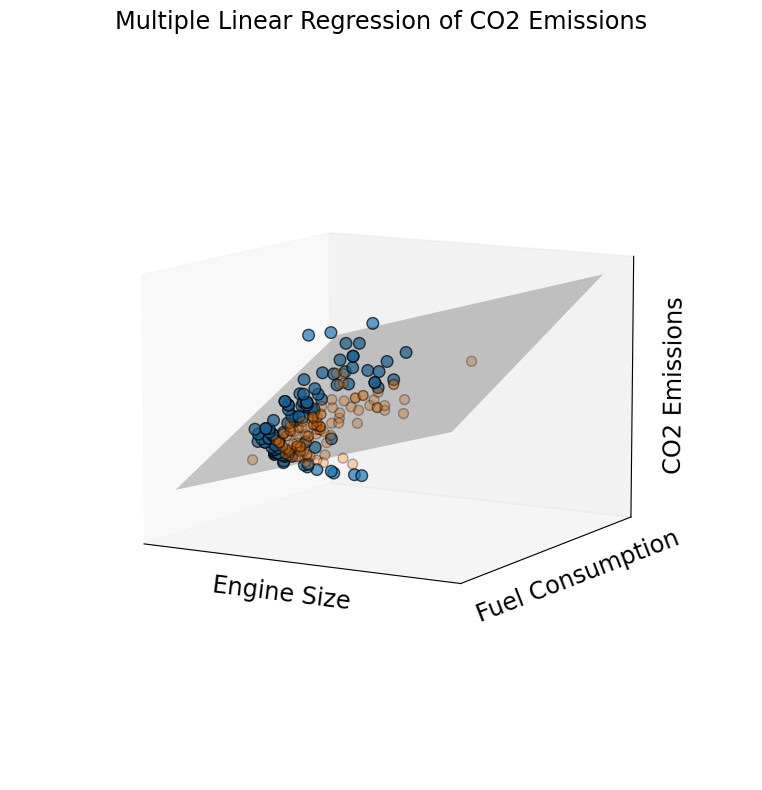

In [215]:
# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test_scaled[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test_scaled[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)

# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

y_surf = intercept + coef[0] * x1_surf + coef[0] * x2_surf

# Predict y values using trained regression model to compare with actual y_test for above/below plane colors
y_pred = lr.predict(X_test_scaled.reshape(-1,1)) if X_test_scaled.ndim == 1 else lr.predict(X_test_scaled)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred

# Plotting
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane], label='Above Plane', s=70, alpha=.7, ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane], label='below Plane', s=50, alpha=.3, ec='k')

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21, label='plane')

# Set view and labels
ax.view_init(elev=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel("Engine Size", fontsize='xx-large')
ax.set_ylabel("Fuel Consumption", fontsize='xx-large')
ax.set_zlabel("CO2 Emissions", fontsize='xx-large')
ax.set_title("Multiple Linear Regression of CO2 Emissions", fontsize='xx-large')
plt.tight_layout()
plt.show()

Instead of making a 3D plot, which is difficult to interpret, we can look at vertical slices of the 3D plot by plotting each variable separately as a best-fit line using the corresponding regression parameters.

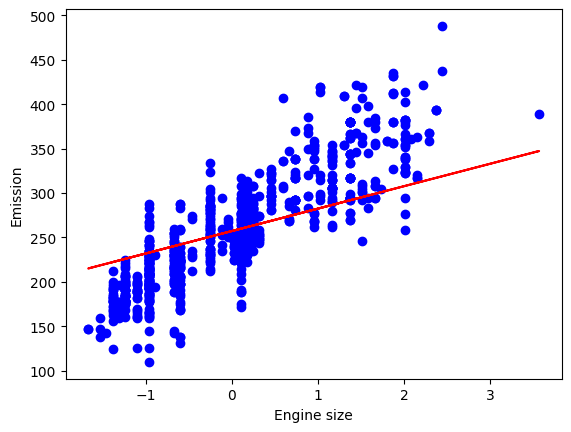

In [211]:
plt.scatter(X_train_scaled[:,0], y_train,  color='blue')
plt.plot(X_train_scaled[:,0], coef[0] * X_train_scaled[:,0] + intercept, '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

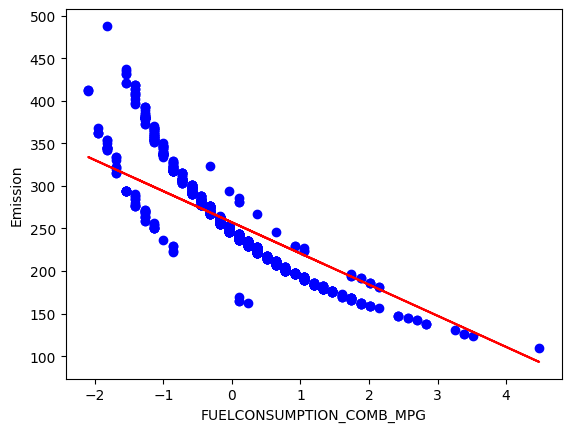

In [212]:
plt.scatter(X_train_scaled[:,1], y_train,  color='blue')
plt.plot(X_train_scaled[:,1], coef[1] * X_train_scaled[:,1] + intercept, '-r')
plt.xlabel("FUELCONSUMPTION_COMB_MPG")
plt.ylabel("Emission")
plt.show()

Evidently, the solution is incredibly poor because the model is trying to fit a plane to a non-planar surface.

In [216]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(root_mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

14.285849104574133
466.1131199661166
21.58965307655768
0.8872746641384827


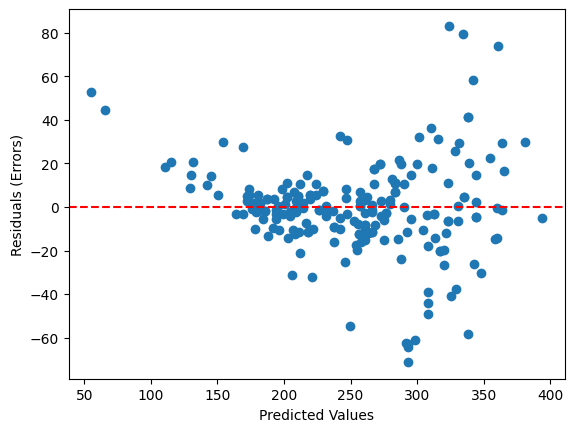

In [217]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Errors)')
plt.show()

The residual actually shows a U-Shaped which is shows that the data shape is non-linear. Let's try to fix this with using **polynomial regression** instead of **linear regression**.

In [220]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Create the "Polynomial Factory" (Degree 2 = squared)
poly = PolynomialFeatures(degree=2)

# 2. Transform the Input (X)
# This turns [Enginsize] into [EngineSize, EngineSize^2]
train_x_poly = poly.fit_transform(X_train)
test_x_poly = poly.fit_transform(X_test)

# 3. Scale or Standardize it
train_x_poly_scaled = scaler.fit_transform(train_x_poly)
test_x_poly_scaled = scaler.transform(test_x_poly)

# 4. Train the same Linear Regression on the NEW data
lr.fit(train_x_poly_scaled, y_train)
coef_poly = lr.coef_
intercept_poly = lr.intercept_

# 5. Evaluate
y_pred_poly = lr.predict(test_x_poly_scaled)

print("Original R2: 0.887")
print(f"Polynomial R2: {r2_score(y_test, y_pred_poly):.4f}")

Original R2: 0.887
Polynomial R2: 0.9025


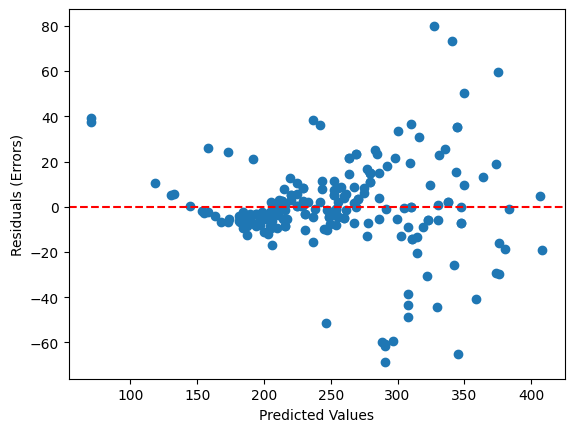

In [221]:
residuals = y_test - y_pred_poly
plt.scatter(y_pred_poly, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Errors)')
plt.show()

/Users/azhar/Documents/python learning/machine_learning_practice/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


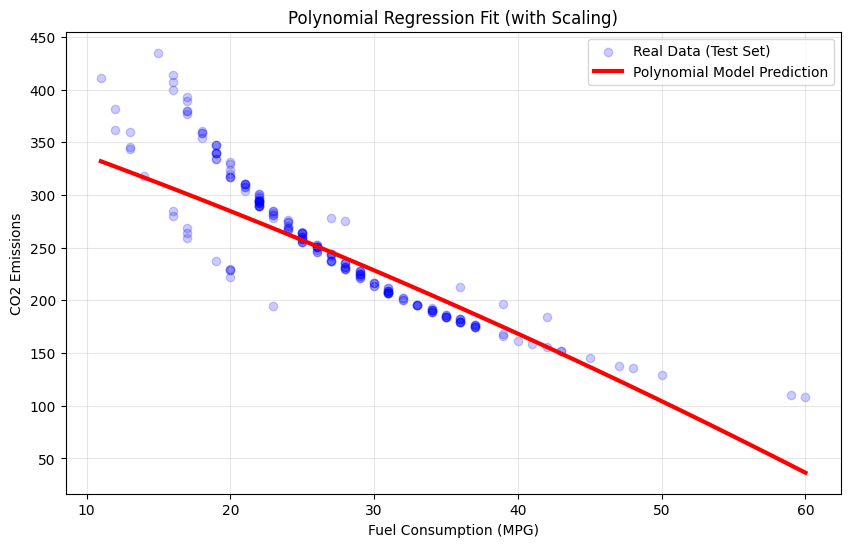

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the range for the X-axis (Fuel Consumption)
# We make 100 points from min to max to get a smooth line
fuel_range = np.linspace(X_test['FUELCONSUMPTION_COMB_MPG'].min(), 
                         X_test['FUELCONSUMPTION_COMB_MPG'].max(), 
                         100).reshape(-1, 1)

# 2. Create a constant for the other variable (Engine Size)
# We use the average engine size so we can isolate the effect of Fuel
engine_constant = np.full(fuel_range.shape, X_test['ENGINESIZE'].mean())

# 3. Stack them to match the input shape: [Engine, Fuel]
# Ensure the order matches how you trained (Engine first, then Fuel)
input_slice = np.column_stack((engine_constant, fuel_range))

# --- THE IMPORTANT PART ---
# 4. Transform using the SAME pipeline as training
# First: Polynomials
input_slice_poly = poly.transform(input_slice)
# Second: Scaling (This is the new step!)
input_slice_scaled = scaler.transform(input_slice_poly)

# 5. Predict
predictions_slice = lr.predict(input_slice_scaled)

# 6. Plot
plt.figure(figsize=(10, 6))

# A. Scatter the REAL data (Test set)
# We use the raw values for plotting so it's readable
plt.scatter(X_test['FUELCONSUMPTION_COMB_MPG'], y_test, color='blue', alpha=0.2, label='Real Data (Test Set)')

# B. Plot the PREDICTED Curve
plt.plot(fuel_range, predictions_slice, color='red', linewidth=3, label='Polynomial Model Prediction')

plt.xlabel("Fuel Consumption (MPG)")
plt.ylabel("CO2 Emissions")
plt.title("Polynomial Regression Fit (with Scaling)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()